# Analysis of PRDE

PRDE - PRZI with Differential Evolution
- *k*: the number of candidate solutions available to choose
- *F*: the differential weight

The goal of this research is to analyse the effects of *k* and *F* on the behaviour of PRDE, and try and produce a (*k*, *F*) pair that outperforms the available agent on GitHub.

### Replicating published results

To gain a better understanding of PRDE and the task at hand, the experiment from **Metapopulation Differential Co-Evolution of
Trading Strategies in a Model Financial Market** will be recreated. The experiment parameters taken from the paper are:

- 30 PRDE sellers
- 30 PRDE buyers
- 300 days of continuous trading time
- 20 total trials
- *k* = 4 (to compare with PRSH)
- *F* = 0.8 (taken from GitHub)

Since time for this research is limited, executing the same number of trials for the same amount of time is infeasible, however, and so only a handful of trials will be run for ~50 trading days. For these reasons, static supply and demand schedules will also be used.

In [155]:
# import dependencies
from BSE import market_session
from BSE_utils import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import csv
import timeit

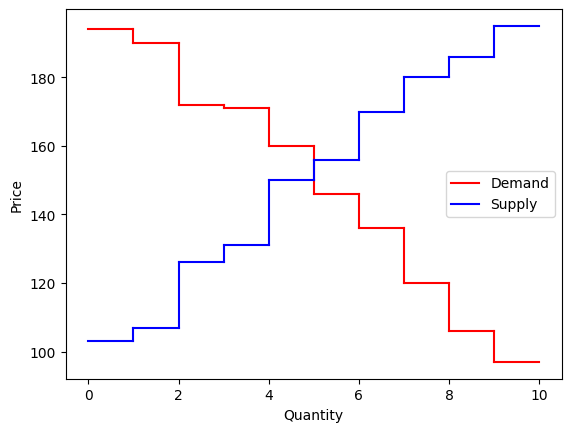

In [156]:
# configure trader specification
sellers_spec = [('PRDE', 30, {'k': 4, 's_min': -1.0, 's_max': +1.0})]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

# confiure the supply and demand (and plot it)
sup_range = (100, 200)
dem_range = (100, 200)

stepmode = 'jittered'

plot_sup_dem(10, [sup_range], 10, [dem_range], stepmode)

# configure order schedules
no_days = 5
start_time = 0
end_time = int(no_days * 24*60*60)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [sup_range], 'stepmode': stepmode}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [dem_range], 'stepmode': stepmode}]

order_interval = 10
timemode = 'drip-jitter'
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': timemode
}

In [157]:
trial_id = 'output/trial_1'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# run market session
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

B00: PRDE active_strat=[0]:
[0]: s=-0.058408, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.907345, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.261834, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.264099, start=0.000000, $=0.000000, pps=0.000000


B01: PRDE active_strat=[0]:
[0]: s=-0.230509, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.586722, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.568712, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.039016, start=0.000000, $=0.000000, pps=0.000000


B02: PRDE active_strat=[0]:
[0]: s=-0.949312, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.151169, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.623593, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.546725, start=0.000000, $=0.000000, pps=0.000000


B03: PRDE active_strat=[0]:
[0]: s=-0.061252, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.677904, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.249152, start=0.000000, $=0.000000, pps=0.0000

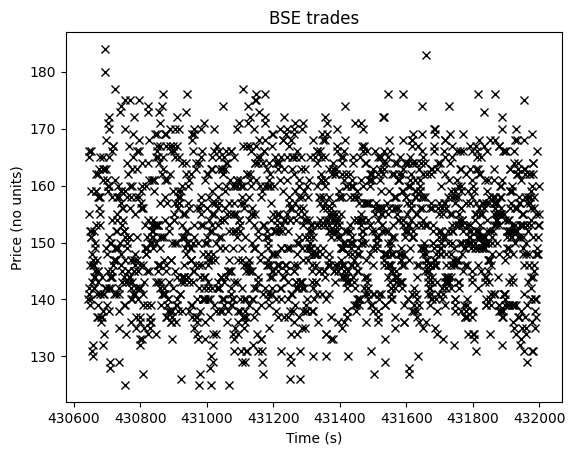

In [158]:
# plot the trades that executed during the market session
plot_trades(trial_id)

In [159]:
def unpack_strats(filename):
    data = []
    best_data = []

    # unpack output file into csv
    with open(filename) as strats:
        reader = csv.reader(strats)

        # each row corresponds with a single eval epoch (7200s)
        for row in reader:
            time = row[1]

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-12].replace(" ", ""),
                        'actvstrat': float(row[-8]),
                        'actvpps': float(row[-10])
                    })

            # extract best buyer per epoch
            best_data.append({
                        't': int(time),
                        'id': row[-6].replace(" ", ""),
                        'actvstrat': float(row[-2]),
                        'actvpps': float(row[-4])
                    })

            # truncate list
            row = row[2:-13]

            # each row contains active pps and strat for each trader
            for i, item in enumerate(row):
                if i % 7 != 0:
                    continue
                else:
                    data.append({
                        't': int(time),
                        'id': row[i+1].replace(" ", ""),
                        'trader': row[i+2].replace(" ", ""),
                        'actvstrat': float(row[i+4]),
                        'actvpps': float(row[i+6])
                    })

        # convert list of dicts into df
        df = pd.DataFrame.from_records(data)
        best_df = pd.DataFrame.from_records(best_data)
    return df, best_df
   
# PRDE strats output file
filename = 'output/trial_1_strats.csv'

prde_df, prde_best_df = unpack_strats(filename)

# convert seconds to days
prde_df['t'] = prde_df['t'] / (24*60*60)
prde_best_df['t'] = prde_best_df['t'] / (24*60*60)

print(df.tail())

           t   id trader  actvstrat  actvpps
7195  428400  S25   PRDE   0.715997      0.0
7196  428400  S26   PRDE   0.459168      0.0
7197  428400  S27   PRDE   1.000000      0.0
7198  428400  S28   PRDE  -0.158416      0.0
7199  428400  S29   PRDE  -0.979266      0.0


In [160]:
print(prde_best_df.tail())

            t   id  actvstrat   actvpps
235  4.875000  S00   0.546272  3.999906
236  4.916667  B29  -0.994191  4.924559
237  4.916667  S00   1.000000  4.434370
238  4.958333  B29  -0.993976  4.561213
239  4.958333  S00   1.000000  4.535708


<AxesSubplot:xlabel='t'>

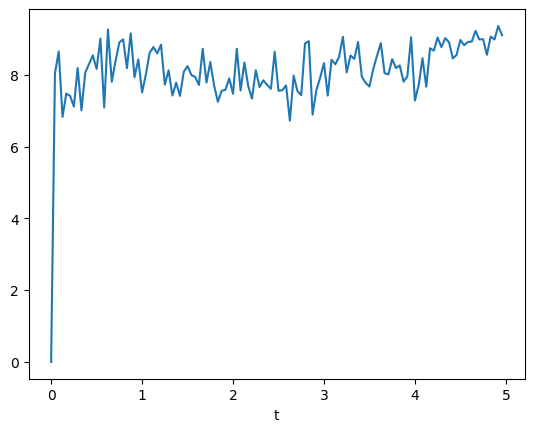

In [161]:
# plot pps for the best traders
prde_best_df.groupby('t').sum()['actvpps'].plot()

<AxesSubplot:xlabel='t'>

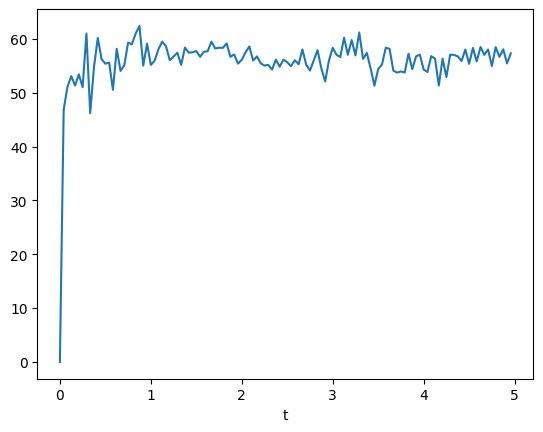

In [162]:
# plot average pps for PRDE
prde_df.groupby('t').sum()['actvpps'].plot()

### Running the same experiment with PRSH for comparison

B00: PRSH active_strat=[0]:
[0]: s=+0.823000, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.731183, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.848673, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.817948, start=0.000000, $=0.000000, pps=0.000000


B01: PRSH active_strat=[0]:
[0]: s=+0.213668, start=0.000000, $=0.000000, pps=0.000000
[1]: s=+0.260371, start=0.000000, $=0.000000, pps=0.000000
[2]: s=+0.247980, start=0.000000, $=0.000000, pps=0.000000
[3]: s=+0.101213, start=0.000000, $=0.000000, pps=0.000000


B02: PRSH active_strat=[0]:
[0]: s=-0.577363, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.559222, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.605316, start=0.000000, $=0.000000, pps=0.000000
[3]: s=-0.548925, start=0.000000, $=0.000000, pps=0.000000


B03: PRSH active_strat=[0]:
[0]: s=-0.484555, start=0.000000, $=0.000000, pps=0.000000
[1]: s=-0.375052, start=0.000000, $=0.000000, pps=0.000000
[2]: s=-0.502568, start=0.000000, $=0.000000, pps=0.0000

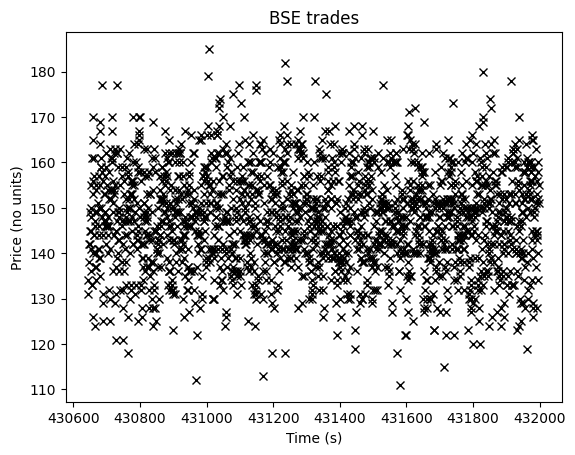

In [89]:
# configure trader specification
sellers_spec = [('PRSH', 30, {'F': 0.8, 'k': 4, 's_min': -1.0, 's_max': +1.0})]
buyers_spec = sellers_spec
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

trial_id = 'output/trial_2'
tdump = open(trial_id + '_avg_balance.csv','w')
dump_all = True
verbose = False

# run market session
# market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

tdump.close()

# plot the trades that executed during the market session
plot_trades(trial_id)

In [118]:
# PRSH strats output file
filename = 'output/trial_2_strats.csv'

prsh_df, prsh_best_df = unpack_strats(filename)

# convert seconds to days
prsh_df['t'] = prsh_df['t'] / (24*60*60)
prsh_best_df['t'] = prsh_best_df['t'] / (24*60*60)

<AxesSubplot:xlabel='t'>

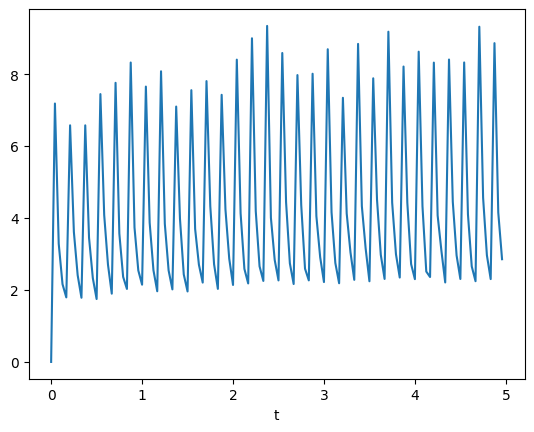

In [121]:
# plot pps for the best traders
prsh_best_df.groupby('t').sum()['actvpps'].plot()

<AxesSubplot:xlabel='t'>

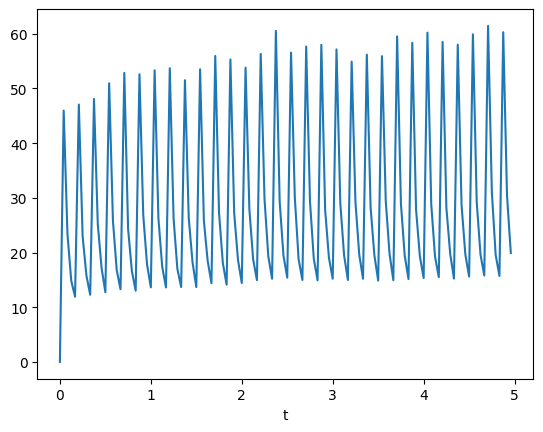

In [120]:
# plot average pps for PRDE
prsh_df.groupby('t').sum()['actvpps'].plot()

## Construct market conditions

The market conditions used to test the traders are important in the validity of the experiments run. The main types of markets that occur are:

- trending (bull or bear)
- trendless (static)
- ranging (moving up and down)

Risk based tests to test the robustness of the trading algorithms:

- Increase supply into the market
- Restrict supply into the market
- Increase demand into the market
- Restrict demand into the market

Constructing supply and demand schedules to properly display these 